In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def interest_points_visualization(I_, kp_data_, ax=None):
    '''
    Plot keypoints chosen by detectos on image.
    Args:
        I_: Image (if colored, make sure it is in RGB and not BGR).
        kp_data_: Nx3 array, as described in assignment.
        ax: Matplotlib axis to plot on (if None, a new Axes object is created).
    Returns:
        ax: Matplotlib axis where the image was plotted.
    '''
    try:
        I = np.array(I_)
        kp_data = np.array(kp_data_)
    except:
        print('Conversion to numpy arrays failed, check if the inputs (image and keypoints) are in the required format.')
        exit(2)

    try:
        assert(len(I.shape) == 2 or (len(I.shape) == 3 and I.shape[2] == 3))
    except AssertionError as e:
        print('interest_points_visualization: Image must be either a 2D matrix or a 3D matrix with the last dimension having size equal to 3.', file=sys.stderr)
        exit(2)

    try:
        assert(len(kp_data.shape) == 2 and kp_data.shape[1] == 3)
    except AssertionError as e:
        print('interest_points_visualization: kp_data must be a 2D matrix with 3 columns.', file=sys.stderr)
        exit(2)

    if ax is None:
        _, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.imshow(I)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    for i in range(len(kp_data)):
        x, y, sigma = kp_data[i]
        circ = Circle((x, y), 3*sigma, edgecolor='g', fill=False, linewidth=1)
        ax.add_patch(circ)

    return ax

In [3]:
def disk_strel(n):
    '''
        Return a structural element, which is a disk of radius n.
    '''
    r = int(np.round(n))
    d = 2*r+1
    x = np.arange(d) - r
    y = np.arange(d) - r
    x, y = np.meshgrid(x,y)
    strel = x**2 + y**2 <= r**2
    return strel.astype(np.uint8)

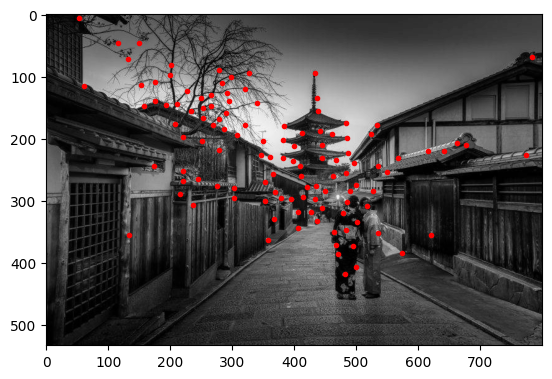

(2, 2)


In [11]:
import cv2
from matplotlib import pyplot as plt
import numpy as np


sigma = 2
r = 2.5
k = 0.1
theta_corn = 0.05
s = 1.5
N = 4


gauss1D = cv2.getGaussianKernel(2, sigma)  # Column vector
gauss2D = gauss1D @ gauss1D.T  # Symmetric gaussian kernel
gauss1Dr = cv2.getGaussianKernel(2, r)  # Column vector
gauss2Dr = gauss1Dr @ gauss1Dr.T  # Symmetric gaussian kernel

I = cv2.imread('kyoto_edges.jpg')
I=cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
I= np.float32(I)

Is = cv2.filter2D(I, -1, gauss2D)

Ix, Iy = np.gradient(Is)

Ix2 = np.square(Ix)
Ixy = Ix * Iy
Iy2 = np.square(Iy)



j1 = cv2.filter2D(Ix2, -1, gauss2Dr)
j2 = cv2.filter2D(Ixy, -1, gauss2Dr)
j3 = cv2.filter2D(Iy2, -1, gauss2Dr)



lambda_plus = 1 / 2 * (j1 + j3 + np.sqrt((j1 - j3) ** 2 + 4 * j2 ** 2))
lambda_minus = 1 / 2 * (j1 + j3 - np.sqrt((j1 - j3) ** 2 + 4 * j2 ** 2))

R = lambda_plus * lambda_minus - k * (lambda_plus + lambda_minus) ** 2

ns = np.ceil(3 * sigma) * 2 + 1
B_sq = disk_strel(ns)
Cond1 =( R == cv2.dilate(R, B_sq))

maxR = np.max(R)
Cond2 = (R > theta_corn * maxR)

# create a binary mask with the same shape as the input image
corners = np.zeros_like(I)

# set the values of the pixels that are corners to 1
corners[Cond1 & Cond2] = 1

plt.imshow(I, cmap='gray')
plt.plot(np.nonzero(corners)[1], np.nonzero(corners)[0], 'r.')
plt.show()










2.2. Πολυκλιμακωτή Ανίχνευση Γωνιών

In [14]:
sigmas= np.zeros(N)
for i in range(0,N):
    sigmas[i]= sigma*s**i

rs= np.zeros(N)
for i in range(0,N):
    rs[i]= r*s**i


2.3. Ανίχνευση Blobs

In [5]:
Lxx= np.gradient(Ix, axis=0)
Lyy= np.gradient(Iy, axis=1)
Lxy= np.gradient(Ix, axis=1)

# Compute determinant and trace
det = Lxx * Lyy - Lxy ** 2
trace = Lxx + Lyy

# Compute response function
k = 0.04
response = det - k * trace ** 2

# Find local maxima
threshold = 0.01 * response.max()
dilated = cv2.dilate(response, np.ones((3,3)))
local_maxima = (response == dilated) & (response > threshold)

# Get coordinates of local maxima
coords = np.column_stack(np.nonzero(local_maxima))

# Draw circles around blobs
radius = 10
color = (0, 255, 0)
thickness = 2
for x, y in coords:
    cv2.circle(I, (y, x), radius, color, thickness)

cv2.imshow('Blobs', I)
cv2.waitKey(0)
cv2.destroyAllWindows()


